#1. Mounting

In [0]:
# Mounting google
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Change Directory
cd /content/gdrive/My Drive/face/face-seg/

/content/gdrive/My Drive/face/face-seg


In [0]:
ls

checkpoints/  dataset.py      nets/      results.png  test.py   weights/
data/         face_seg.ipynb  README.md  save/        train.py


In [0]:
# Import
import cv2

import torch
from torch.autograd import Variable
import torchvision

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as dset
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import interpolate
import torch.optim as optim

import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps 

import numpy as np

import random
import logging
import sys

# Glob module: UNIX shell
import glob
# Regex
import re

In [0]:
# Gets the name of a device.
print(torch.cuda.get_device_name())
print(torch.cuda.device_count())

# Monitoring GPU
print("GPU Information")
!nvidia-smi

Tesla K80
1
GPU Information
Wed Nov  6 18:48:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    29W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

- Helper Functions

In [0]:
def show_plot(iteration,loss):
  plt.plot(iteration,loss)
  plt.show()

# + Dataset: LFW(Labeled Face in Wild)

+ images 13,233
- 5749 people
- 1680 people with two or more images
+ masks 2,927

In [0]:
class Config():
    in_dir = "./data/raw/"

    img_dir = "./data/raw/images/"
    mask_dir = "./data/raw/masks/"

    saving_dir = "./save/"
    train_batch_size = 8
    train_number_epochs = 25

    log_interval = 10

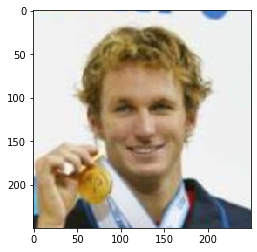

(250, 250, 3)


In [0]:
# Images example with size(250, 250, 3) - (H,W,C)
x = Image.open(Config.img_dir + "Aaron_Peirsol_0001.jpg")
plt.imshow(x)
plt.show()
x = np.asarray(x)
print(x.shape)

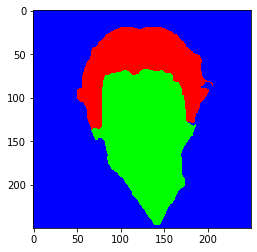

(250, 250, 3)


In [0]:
# Masks example with size(250, 250, 3) - (H,W,C)
x = Image.open(Config.mask_dir + "Aaron_Peirsol_0001.ppm" )
plt.imshow(x)
plt.show()
x = np.asarray(x)
print(x.shape)

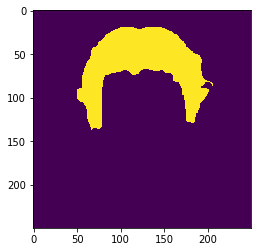

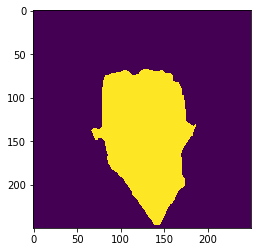

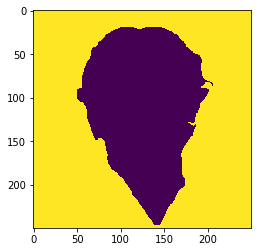

In [0]:
x = Image.open(Config.mask_dir + "Aaron_Peirsol_0001.ppm" )

x = np.asarray(x)
# 0: Hair
y = x[:,:,0]
y = Image.fromarray(y)
plt.imshow(y)
plt.show()

# 1: Face
z = x[:,:,1]
z = Image.fromarray(z)
plt.imshow(z)
plt.show()

# 2: Background
w = x[:,:,2]
w = Image.fromarray(w)
plt.imshow(w)
plt.show()

#2. Dataset / Dataloader

In [0]:
# /images/~ ex) Aaron_Peirsol_0001.jpg
# /masks/~ ex) Aaron_Peirsol_0001.ppm

# Mask(.ppm) to img(.jpg)
def mask_to_img(mask_file):
  # re.sub(pattern, repl, string)
  img_file = re.sub('masks', 'images', mask_file)
  img_file = re.sub('\.ppm$', '.jpg', img_file)
  return img_file


In [0]:
class MaskDataset(Dataset):
  def __init__(self, path='./data/raw', transform=None):
    # Entire masks file().ppm
    self.mask_files = sorted(glob.glob('{}/masks/*.ppm'.format(path)))
    self.img_files = [mask_to_img(f) for f in self.mask_files]
    self.transform = transform
    self._data_len = len(self.img_files)

  def __getitem__(self, idx):
    # cv2 base on BGR so necessary to transposing
    img = cv2.imread(self.img_files[idx])
    # BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.mask_files[idx])

    seed = random.randint(0, 2 ** 32)
        
    if self.transform is not None:

      random.seed(seed)
      img = Image.fromarray(img)
      img = self.transform(img)

      random.seed(seed)
      mask = Image.fromarray(mask)
      mask = self.transform(mask)

    mask = np.array(mask)
    
    labels = np.zeros_like(mask[0, :, :])

    # Hair
    labels[np.where(mask[1, :, :] > 0)] = 1
    # Face
    labels[np.where(mask[2, :, :] > 0)] = 2  
    
    return img, np.int64(labels)

    def __len__(self):
        return self._data_len

In [0]:
def gen_dataloaders(indir, val_split = 0.05, shuffle = True, batch_size = 4, seed = 42, img_size = 224, cuda=True):

  data_transforms = {
    'train': transforms.Compose([
      # transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
      transforms.RandomResizedCrop(img_size, scale=(0.1, 1.0)),
      transforms.RandomAffine(10.),
      transforms.RandomRotation(13.),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
      transforms.Resize((img_size, img_size)),
      transforms.ToTensor(),
    ])
  }

  mask_train_dataset = MaskDataset(path = indir,transform=data_transforms['train'])
  mask_valid_dataset = MaskDataset(path = indir,transform=data_transforms['valid'])

  # Creating data indices for training and validation splits:
  dataset_size = mask_train_dataset._data_len
  indices = list(range(dataset_size))

  split = int(np.floor(val_split * dataset_size))
    
  if shuffle:
    np.random.seed(seed)
    np.random.shuffle(indices)

  train_indices, val_indices = indices[split:], indices[:split]

  # Creating data samplers and loaders
  train_sampler = SubsetRandomSampler(train_indices)
  valid_sampler = SubsetRandomSampler(val_indices)

  kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}

  train_loader = torch.utils.data.DataLoader(mask_train_dataset, num_workers=0, batch_size = batch_size, sampler = train_sampler)
    
  valid_loader = torch.utils.data.DataLoader(mask_valid_dataset, num_workers=0, batch_size = batch_size, sampler = valid_sampler)
  
  return train_loader, valid_loader

In [0]:
train_loader, valid_loader = gen_dataloaders(indir = './data/raw', batch_size = Config.train_batch_size)

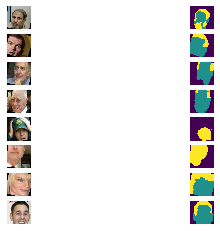

In [0]:
images, masks = next(iter(train_loader))
fig = plt.figure()

images = images.permute(0, 2, 3, 1).numpy()
#masks = masks.permute(0, 2, 3, 1).numpy()

for i, (image, mask) in enumerate(zip(images, masks)):
  
  ax = plt.subplot(Config.train_batch_size, 2, 2 * i + 1)
  #ax.set_title('image')
  ax.axis('off')
  ax.imshow(image.squeeze())

  ax = plt.subplot(Config.train_batch_size, 2, 2 * i + 2)
  #ax.set_title('mask')
  ax.axis('off')
  ax.imshow(mask.squeeze())

plt.show()

# 3. Network crafting

In [0]:
print(models.vgg16().features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [0]:
# For Encoder, Decoder block
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class Interpolate(nn.Module):
    def __init__(self, size=None, scale_factor=None, mode='nearest', align_corners=False):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        self.scale_factor = scale_factor
        self.align_corners = align_corners
        
    def forward(self, x):
        x = self.interp(x, size=self.size, scale_factor=self.scale_factor, 
                        mode=self.mode, align_corners=self.align_corners)
        return x

class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                Interpolate(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)

In [0]:
class UNet16(nn.Module):
    def __init__(self, num_classes=3, num_filters=32, pretrained=False, is_deconv=True):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network used
            True - encoder pre-trained with VGG16
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.vgg16(pretrained=pretrained).features        
        # self.encoder = torchvision.models.vgg16_bn(pretrained=pretrained).features

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu,
                                   self.encoder[2],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5],
                                   self.relu,
                                   self.encoder[7],
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],
                                   self.relu,
                                   self.encoder[12],
                                   self.relu,
                                   self.encoder[14],
                                   self.relu)

        self.conv4 = nn.Sequential(self.encoder[17],
                                   self.relu,
                                   self.encoder[19],
                                   self.relu,
                                   self.encoder[21],
                                   self.relu)

        self.conv5 = nn.Sequential(self.encoder[24],
                                   self.relu,
                                   self.encoder[26],
                                   self.relu,
                                   self.encoder[28],
                                   self.relu)

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)

        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder part
        conv1 = self.conv1(x)
        #print(conv1.shape)
        conv2 = self.conv2(self.pool(conv1))
        #print(conv2.shape)
        conv3 = self.conv3(self.pool(conv2))
        #print(conv3.shape)
        conv4 = self.conv4(self.pool(conv3))
        #print(conv4.shape)
        conv5 = self.conv5(self.pool(conv4))
        #print(conv5.shape)

        center = self.center(self.pool(conv5))
        #print(center.shape)

        # Decoder part & Skip connection
        dec5 = self.dec5(torch.cat([center, conv5], dim=1))
        
        dec4 = self.dec4(torch.cat([dec5, conv4], dim=1))
        
        dec3 = self.dec3(torch.cat([dec4, conv3], dim=1))
        
        dec2 = self.dec2(torch.cat([dec3, conv2], dim=1))
        
        dec1 = self.dec1(torch.cat([dec2, conv1], dim=1))
        

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)
            
        #print(x_out.shape)

        return x_out

# 4. Training

In [0]:
# Settings
net = UNet16().cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 3e-4)

================== Epoch: 1 ==================
Epoch number 1
 Current loss 1.0484604835510254

Epoch number 1
 Current loss 1.0026774406433105

Epoch number 1
 Current loss 0.9489455223083496

Epoch number 1
 Current loss 0.8453690409660339

Epoch number 1
 Current loss 0.8792493939399719

Epoch number 1
 Current loss 0.7363309860229492

Epoch number 1
 Current loss 0.674468994140625

Epoch number 1
 Current loss 0.7315686941146851

Epoch number 1
 Current loss 0.7077105641365051

Epoch number 1
 Current loss 0.5904656648635864

Epoch number 1
 Current loss 0.651343584060669

Epoch number 1
 Current loss 0.5789673924446106

Epoch number 1
 Current loss 0.5632236003875732

Epoch number 1
 Current loss 0.6095118522644043

Epoch number 1
 Current loss 0.6022428274154663

Epoch number 1
 Current loss 0.7034293413162231

Epoch number 1
 Current loss 0.6395235061645508

Epoch number 1
 Current loss 0.4937800467014313

Epoch number 1
 Current loss 0.4414464235305786

Epoch number 1
 Current 

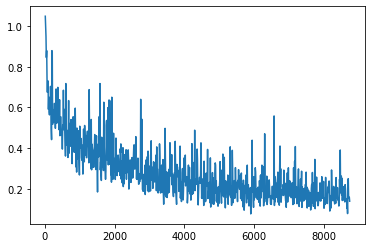

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(1, Config.train_number_epochs +1):
  print("================== Epoch: {} ==================".format(epoch))
  
  # i: batch_idx
  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()

    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()
  
    if i % Config.log_interval != 0:
      continue

    if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())

show_plot(counter,loss_history)

#5. Saving and Loading

In [0]:
# Print model's state_dict

print("Model's state_dict:")
for param_tensor in net.state_dict():
  print(param_tensor, "\t", net.state_dict()[param_tensor].size())
  
# Print optimizer's state_dict

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
encoder.0.weight 	 torch.Size([64, 3, 3, 3])
encoder.0.bias 	 torch.Size([64])
encoder.2.weight 	 torch.Size([64, 64, 3, 3])
encoder.2.bias 	 torch.Size([64])
encoder.5.weight 	 torch.Size([128, 64, 3, 3])
encoder.5.bias 	 torch.Size([128])
encoder.7.weight 	 torch.Size([128, 128, 3, 3])
encoder.7.bias 	 torch.Size([128])
encoder.10.weight 	 torch.Size([256, 128, 3, 3])
encoder.10.bias 	 torch.Size([256])
encoder.12.weight 	 torch.Size([256, 256, 3, 3])
encoder.12.bias 	 torch.Size([256])
encoder.14.weight 	 torch.Size([256, 256, 3, 3])
encoder.14.bias 	 torch.Size([256])
encoder.17.weight 	 torch.Size([512, 256, 3, 3])
encoder.17.bias 	 torch.Size([512])
encoder.19.weight 	 torch.Size([512, 512, 3, 3])
encoder.19.bias 	 torch.Size([512])
encoder.21.weight 	 torch.Size([512, 512, 3, 3])
encoder.21.bias 	 torch.Size([512])
encoder.24.weight 	 torch.Size([512, 512, 3, 3])
encoder.24.bias 	 torch.Size([512])
encoder.26.weight 	 torch.Size([512, 512, 3, 3])
encoder.26.b

In [0]:
# Saving
torch.save(net.state_dict(), Config.saving_dir + 'model_inference.pth')

# Loading
'''
net = TheModelClass(*args, **kwargs)
net.load_state_dict(torch.load(Config.saving_dir))
net.eval()
'''

'\nnet = TheModelClass(*args, **kwargs)\nnet.load_state_dict(torch.load(Config.saving_dir))\nnet.eval()\n'

- Saving

In [0]:
# Saving
torch.save(net, Config.saving_dir+ "test_model.pth")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type UNet16. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/

'\nnet = torch.load(Config.saving_dir)\nnet.eval()\n'

#6. Test

- Loading

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Loading (Model class must be defined somewhere)
model = UNet16()
model.eval()
model.to(device)
#state_dict = torch.load(Config.saving_dir + "test_model.pth")
state_dict = torch.load(Config.saving_dir + 'model_inference.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

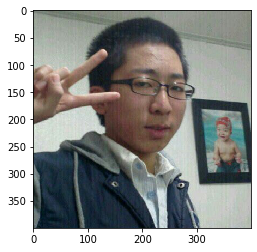

In [0]:
t = Image.open(Config.in_dir + "test6.jpg")
plt.imshow(t)
plt.show()
#t = np.asarray(t)
#print(t.shape)

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

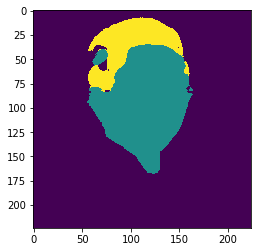

In [0]:
with torch.no_grad():
  t_input = img_transform(t)
  t_input = t_input.unsqueeze(0)
  t_input = t_input.to(device)

  # Forward Pass
  logits = model(t_input)
  mask = np.argmax(logits.data.cpu().numpy(), axis=1)
  plt.imshow(mask.squeeze())
  plt.show
  '''
  # Plot
  ax = plt.subplot(2, args.batch_size, 2 * i + 1)
  ax.axis('off')
  ax.imshow(image.squeeze())

  ax = plt.subplot(2, args.batch_size, 2 * i + 2)
  ax.axis('off')
  ax.imshow(mask.squeeze())

  plt.show()
  '''
                              
                              